
## PRÁCTICA 2 - Métodos Avanzados en Aprendizaje Automático
## Gradient Boosting

### Guillermo Hoyo Bravo y Adrián Rubio Pintado  -  Master Ciencia de Datos 2021

En esta práctica vamos a hacer una implementación propia del algoritmo de aprendizaje automático Gradient Boosting y a hacer posteriormente una comparativa con la implementación de la librería sklearn para el mismo algoritmo.


La implementación Gradient Boosting utilizará árboles de decisión como algoritmos base. Empleando la técnica boosting, propia de los conjuntos de clasificadores), conseguiremos a partir de varios clasificadores débiles conectados en serie, un clasificador resultante robusto.

Solo se va a implementar Gradient Boosting para regresión y para clasificación binaria con clases igual a -1 y +1. Para ello se implementará la clase genérica GBCasero, que hará uso de SquaredErrorLoss o LogLoss según sea un problema de regresión o clasificación, ya que las funciones de pérdida a optimizar son distintas.

### Funciones auxiliares 
Las utilizaremos para poder analizar la implementación del algoritmo.

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()

In [4]:
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

In [5]:
def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

### Código

Para regresión implementamos la clase SquaredErrorLoss:

In [214]:
class SquaredErrorLoss:
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión """
    
        
    def __init__(self):
        self.type = 'Regressor'
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return np.mean(y)

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return y-F

    ## CAMBIO 01
    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado al arbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        #multiplicador = 1 en SquarredErrodLoss
        return valor
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return 0.5*(y-F)**2

Para clasificación implementamos la clase LogLoss:

In [264]:
class LogLoss:
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def __init__(self):
        self.type = ' Classifier'
        
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        #y e {-1,1}
        media = np.mean(y)
        return 0.5 * np.log( (1+ media) / (1-media) )

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return (2.0*y) / (1+ np.exp(2.0*y*F))

    ## CAMBIO 02
    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        abs_residuos = np.abs(residuos)
        num = np.sum(residuos)
        denom = np.sum(abs_residuos*(2-abs_residuos))
        # Prevent by zero divison
        multiplicador = np.divide(num, denom, out=np.zeros_like(sum), where= denom!=0)
        return multiplicador
        #return multiplicador * valor

    def __call__(self,y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return np.log(1+np.exp(-2.0*y*F))

Implementamos ahora la versión genérica del algoritmo para regresión/clasificación

In [371]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import check_X_y
class GBCasero:
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self.depth        = depth # max trees depth
        self.eta          = eta # learning rate
        # La implementación de loss se usará en fit para crear el algoritmo
        # GB de forma genérica.
        self.loss         = loss
    
    def fit(self,X,y):
        """
          Entrena el algoritmo utilizando arboles de decision
          Emplea la clase loss para poder utilizar el algoritmo
          de forma génerica en regresion y clasificación
        """
        
        #Check the inputs
        check_X_y(X,y)
        if(self.loss.type ==  'Classifier'):
            assert (np.abs(a) == 1).all(), 'For Classifier method all clasess must be 1 or -1'
        
        
        self.F0 = self.loss.F0(X, y)
        F = np.full(y.shape, self.F0)
        
        
        for m in range(self.n_estimators):
    
            tree = DecisionTreeRegressor(max_depth = self.depth)
           
            # 1 Compute the pseudo-residuals for each instance
            residuos= self.loss.residuos(y, F)
            
            # 2 Fit a regressor h(x) on residuals, Va a aprender lo que falta de los datos
            # tree = h_t
            tree.fit(X,residuos )
            
            # 3 Compute multiplier amd update the tree leafs
            #  h_t = ro*h_t
            self.paso_newton_general(tree, X, y, residuos)
            
            # 4 Update model
            self._estimators.append(tree)
            F +=  self.eta * tree.predict(X)
            
        return self
            
            
    def predict(self,X):
        """ Combinamos los valores de pesos y hs para obtener la 'salida', y:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable """
        
        assert X.ndim == 2, 'X must be a 2D matrix'
        
        result =  np.full(X.shape[0], self.F0)
        
        for tree in self._estimators:
            result += self.eta * tree.predict(X)
            
        if(self.loss.type ==  'Regressor'):
            return result
        else:#Classifier output
            return np.sign(result)
            
    ## CAMBIO 03
    def paso_newton_general(self, tree, X, y, residuos):
        """ Esta función actualiza todas las hojas de salida
            del árbol 'tree' utilizado la función paso_newton_hoja
            de las clases de funcion de pérdida """
        TREE_LEAF = -1
        tree = tree.tree_
        leaf_indices = tree.apply(np.array(X,dtype=np.float32))
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = leaf_indices==leaf
            tree.value[leaf,0,0] = self.loss.paso_newton_hoja(y[ii],
                                                              residuos[ii],
                                                              tree.value[leaf,0,0])


# Testeo del Código 
## Regresión

Empleamos primero un ejemplo de dos clases para regresión y comparamos el error y frontera de decisión obtenidos con la implementación de sklearn.

#### Ejemplo 1

In [334]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

Generamos los datos y los graficamos

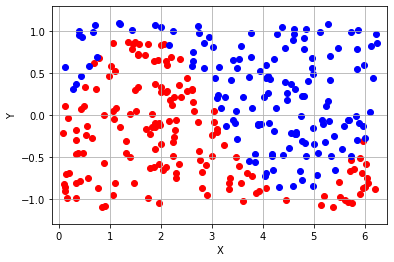

In [335]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0           # <========= Modifica este valor 0 ó 0.3,
x1, x2, ytrain, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
x1test, x2test, ytest = createDataSet(n*10, model, ymargin, noise)
plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})
Xtrain = np.concatenate((x1, x2), axis = 1)
Xtest = np.concatenate((x1test, x2test), axis = 1)

##### **Gradient Boosting Casero**

Test MSE sklearn: 0.025459547846088063


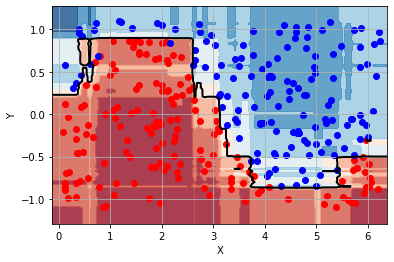

In [363]:
gb_casero = GBCasero(n_estimators=100, loss=SquaredErrorLoss(), eta=0.1, depth=3)
gb_casero.fit(Xtrain, ytrain)
plotModel(x1,x2,ytrain,gb_casero)
print("Test MSE sklearn:" , np.mean(   SquaredErrorLoss()(ytest, gb_casero.predict(Xtest))) )

##### **Sklearn**

Test MSE sklearn: 0.025449039122754775


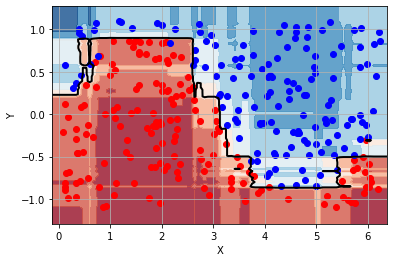

In [364]:
gb_sk = GradientBoostingRegressor(n_estimators=100,criterion="mse",learning_rate=0.1,max_depth=3, random_state=123)
gb_sk.fit(Xtrain, ytrain)
plotModel(x1,x2,ytrain,gb_sk)
print("Test MSE sklearn:" , np.mean(   SquaredErrorLoss()(ytest, gb_sk.predict(Xtest))) )

Para calcular el error de los modelos utilizamos el **MSE o error cuadrático medio**, que puede ser interpretado como la distancia media entre nuestras predicciones y los valores reales. Observamos como para el ejemplo dado obtenemos el mismo porcentaje de error y prácticamente la misma frontera de decisión(con los datos de train) que la implementación de sklearn, lo cual nos sirve para validar nuestro código. Dado que solo disponíamos de 2 clases vamos a testearlo con un dataset de regresión más adecuado.

#### Ejemplo 2

Para este caso utilizamos el dataset de 'boston' de sklearn, que permite predecir el precio de la vivienda.

In [365]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_absolute_error

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target)

X_train, X_test, y_train, y_test = train_test_split(X, y)

 Para unos hiperparámetros optimizados empíricamente(no al máximo) de igual valor para los 2 algoritmos, obtenemos un MSE de:

##### **Gradient Boosting Casero**

In [369]:
gb_casero_boston = GBCasero(n_estimators=100, loss=SquaredErrorLoss(), eta=0.1, depth=3)
gb_casero_boston.fit(X_train, y_train)
y_pred_gb_casero_boston = gb_casero_boston.predict(X_test)
mean_absolute_error(y_test, y_pred_gb_casero_boston)

2.384943730142947

##### **Sklearn**

In [370]:
gb_sk_boston = GradientBoostingRegressor(max_depth=3, n_estimators=100,learning_rate=0.1)
gb_sk_boston.fit(X_train, y_train)
y_pred_gb_sk_boston = gb_sk_boston.predict(X_test)
mean_absolute_error(y_test, y_pred_gb_sk_boston)

2.401279338613909

De nuevo vemos como nuestro modelo da para los mismos hiperparámetros un error prácticamente similar, lo que nos permite **validar nuestra implementación para regresión** del algoritmo de Gradient Boosting.

## Clasificación

Dado que las clases generadas por nuestra función de creación de datasets son 0 y 1, convertimos los 0's en -1's, ya que  utilizamos la función signo para distinguir entre las dos clases posibles(1 y -1).
Utilizamos de nuevo los datos creados para el primer ejemplo de regresión(con 2 clases) y comparamos el error y la frontera de decisión(con los datos de train) de nuestra implementación de GB para clasificación con la de sklearn.

Dado que estamos en clasificación, es decir, el dominio del problema, utilizamos como métrica de rendimiento de los modelos el accuracy(precisión), con ella podemos ver la fracción de prediciones que los modelos han pronosticado correctamente.

In [348]:
from sklearn.metrics import accuracy_score

ytrain_classif = np.where(ytrain==0, -1 ,ytrain) 
ytest_classif =  np.where(ytest==0, -1 ,ytest) 

##### **Gradient Boosting Casero**

Test Error Log loss GB Casero: 0.22692801104297264
Accuracy Log loss GB Casero:  0.95


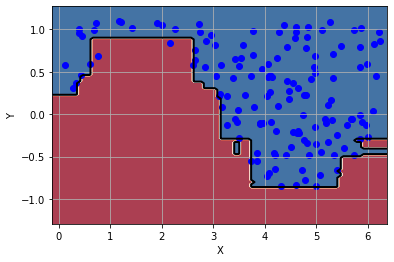

In [351]:
gb_casero_cla = GBCasero(n_estimators=100, loss=LogLoss(), eta=0.1, depth=3)
gb_casero_cla.fit(Xtrain, ytrain_classif)
plotModel(x1,x2,ytrain_classif,gb_casero_cla)
gb_casero_cla_predictions = gb_casero_cla.predict(Xtest)
print("Test Error Log loss GB Casero:" , np.mean(   LogLoss()(ytest_classif,gb_casero_cla_predictions )) )
print('Accuracy Log loss GB Casero: ', accuracy_score(ytest_classif, gb_casero_cla_predictions ) )

##### **Sklearn**

Test Error Log loss sklearn: 0.22692801104297264
Accuracy Log loss GB sklearn:  0.95


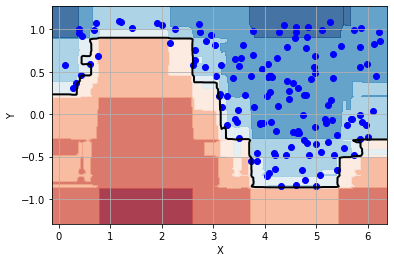

In [352]:
gb_sk_cla = GradientBoostingClassifier(n_estimators=100,criterion="mse",learning_rate=0.1,max_depth=3, random_state=123)
gb_sk_cla.fit(Xtrain, ytrain_classif)
plotModel(x1,x2,ytrain_classif,gb_sk_cla)
gb_sk_cla_predictions = gb_sk_cla.predict(Xtest)
print("Test Error Log loss sklearn:" , np.mean(   LogLoss()(ytest_classif, gb_sk_cla_predictions)) )
print('Accuracy Log loss GB sklearn: ', accuracy_score(ytest_classif, gb_sk_cla_predictions ) )

En ambos modelos obtenemos una precisión del 95%(para los hiperparámetros seleccionados). De nuevo vemos como nuestro modelo da un error y un accuracy prácticamente similar al de sklearn, lo que nos permite **validar nuestra implementación para clasificación** del algoritmo de Gradient Boosting.

# BORRAR ESTO DE LOS TIEMPOS

In [358]:

import timeit


n_executions = 10


# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    gb_casero_boston.fit(X_train, y_train)
toc = timeit.default_timer()

print("Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(X_train),(toc - tic)/n_executions))


Tiempo de entrenamiento con 379 ejemplos: 0.4732 s.


In [359]:
import timeit


n_executions = 10


# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    gb_sk_boston.fit(X_train, y_train)
toc = timeit.default_timer()

print("Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(X_train),(toc - tic)/n_executions))


Tiempo de entrenamiento con 379 ejemplos: 0.1017 s.
